Pipelineクラスを用いて、データ変換とモデル実行のチェーン構築を簡単に行う

In [1]:
# データを分割→最大値と最小値を求めてデータのスケール変換→SVMで訓練
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import pandas as pd
import mglearn

from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# データをロードして分割
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

# 訓練データの最小値と最大値を計算
scaler = MinMaxScaler().fit(X_train, y_train)

In [2]:
# 訓練データをスケール変換
X_train_scaled = scaler.transform(X_train)

svm = SVC()
svm.fit(X_train_scaled, y_train)
# テストデータをスケール変換して、評価
X_test_scaled = scaler.transform(X_test)
print(f"Test score: {svm.score(X_test_scaled, y_test):.2f}")

Test score: 0.97


In [3]:
# GridSearchCVでSVCのより良いパラメータを求める
from sklearn.model_selection import GridSearchCV
# 説明用のコード。こんなふうに書いてはいけない！
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}") # あくまでも訓練セットを用いた最良のパラメータでのスコア
print(f"Best set score: {grid.score(X_test_scaled, y_test):.2f}")
print(f"Best parameters: {grid.best_params_}")

Best cross-validation accuracy: 0.98
Best set score: 0.97
Best parameters: {'C': 1, 'gamma': 1}


ここでは、訓練セットの全てのデータを用いてスケール変換を行っている→交差検証の際に、訓練データとして使われないデータ(交差検証時のテストデータ)も用いてスケール変換が行われてしまっている

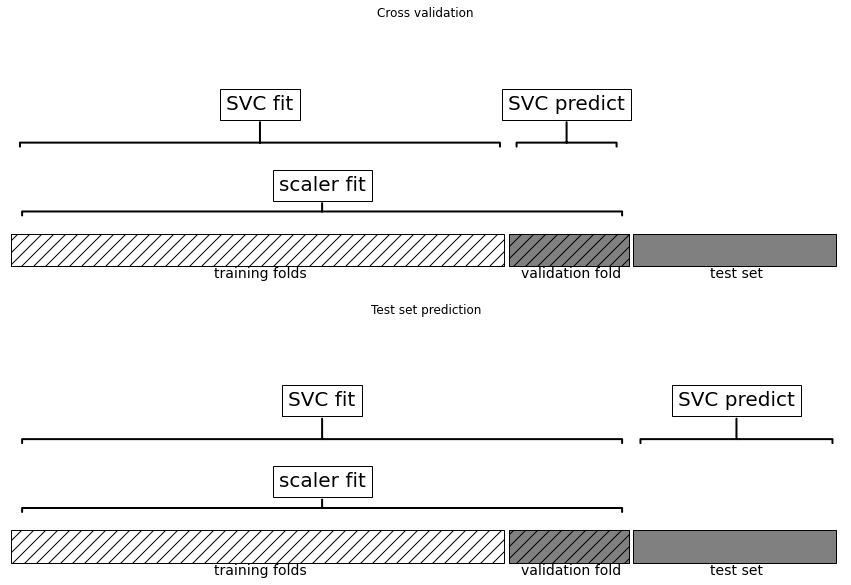

In [4]:
# 交差検証の際と最終的な評価の際のデータ処理の違い
mglearn.plots.plot_improper_processing()
# 前処理をする前に交差検証のためのデータ分割をする必要がある

Pipelineクラスを用いると、複数の処理ステップを糊付けし、1つのscikit-learnのEstimatorにすることができる


# パイプラインの構築 P.302

MinMaxScalerによるスケール変換を行ってからSVMを訓練するワークフローを表現する方法を見てみる。(グリッドサーチは行わない)

各ステップをリストとして指定して、Pipelineオブジェクトを作る。ここのステップは、名前*1とEstimatorのインスタンスをタプルで表す

*1: 連結したアンダースコア(__)を含んではいけない。

In [5]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', MinMaxScaler()),('svm', SVC())])

In [6]:
# 他のEstimatorと同じようにfitメソッドを呼び出す
pipe.fit(X_train, y_train)
# scalerのfitを呼び出して、訓練データをscalerを用いて変換し、SVMを変換されたデータを用いでfitする。

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [7]:
# テストデータで評価
print(f"Test score: {pipe.score(X_test, y_test):.2f}")

Test score: 0.97


In [8]:
# グリッドサーチの実行 詳しくはP.303
# パラメータの名前の指定方法が大事
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [9]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best parameters: {grid.best_params_}")
# これで、交差検証で個々に分割してから→訓練用のパートのみを対象としてMinMaxScalerをfitし直すから、テストパートがパラメータサーチに漏れない

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


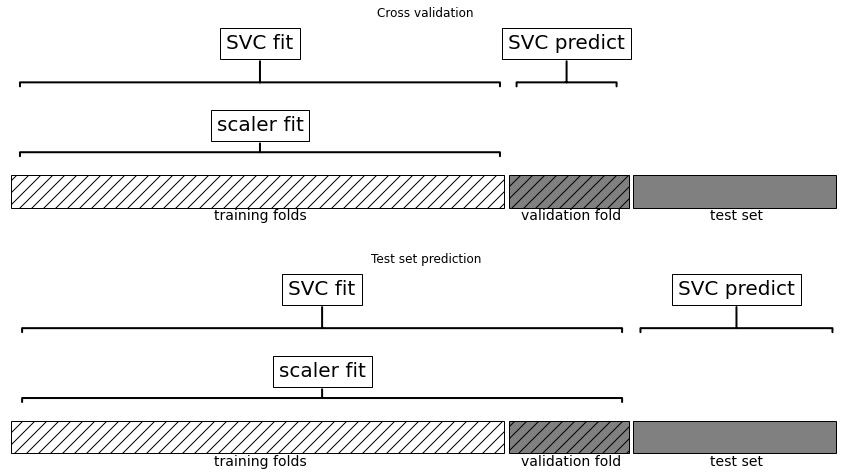

In [10]:
mglearn.plots.plot_proper_processing()

交差検証で情報がリークすることの影響が、前処理ステップの性質に依存。

データ変換のスケールをテストデータを用いることはそれほど大きな影響はないが、特徴量抽出や特徴量選択でかなりの影響が出る。

例として、10,000の特徴量を持つ100サンプルの合成回帰タスクを考える。全てのデータを独立にガウス分布からサンプリングし、レスポンスもガウス分布からサンプリングする。

In [11]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))
# データとターゲットの間にはなんの関係もなく、学習できることはないはず

In [12]:
# Selectpipeline特徴量抽出を使って、10個の最も情報の多い特徴量を抽出し、交差検証を用いてRidge回帰を検証
from sklearn.feature_selection import SelectPercentile, f_regression
select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print(f"X_selected.shape: {X_selected.shape}")

X_selected.shape: (100, 500)


In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("Cross-validation accuracy (cv only on ridge): {:.2f}".format(np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))
# かなり良いモデルになっているが、完全にランダムなはずだから正しくない

Cross-validation accuracy (cv only on ridge): 0.91


交差検証の**外**で特徴量抽出を行ったから、訓練セットでもテストセットでもターゲットに相関のある特徴量が得られてしまった→非現実的な結果に

In [14]:
# パイプラインで適切な交差検証を行う
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression, percentile=5)),
                 ("ridge", Ridge())])
print("Cross-validation accuracy (pipeline): {:.2f}".format(np.mean(cross_val_score(pipe, X, y, cv=5))))
# 交差検証ループの内側で特徴量抽出が行われているため、テスト用部分は用いず、訓練用の部分のみに対して行われるようになった

Cross-validation accuracy (pipeline): -0.25


# 汎用パイプラインインターフェイス

Pipelineクラスが適用できるのは、前処理とクラスタ分類だけでなく、任意個数のEstimatorを連結できる。

例: 特徴量抽出→特徴量選択→スケール変換→クラス分類

Rstimatorに関する制約は、最後以外のステップには次のステップで使う新しいデータ表現を生成するために`transform`メソッドが定義されていること。

pipeline.stepsはタプルのリストだから、pipeline.steps[0][1]が最初のEstimator、pipeline.steps[1][1]が2番目のEstimatorというようになっている。
(0列目は名前)

In [15]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # 最後のステップ以外で、fitとtransformを順に実行
        X_transformed = estimator.fit_transform(X_transformed, y)
    # 最後のステップでfit
    self.steps[-1][1].fit(X_transformed. y)
    return self

In [16]:
# Pipelineを用いて予測を行う際は、同様に最後のステップ以外でデータに対してtransformを、最後のステップではpredictを呼び出す
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        X_transformed = step[1].transform(X_transformed)
    # 最後のステップでpredict
    return self.steps[-1][1].predict(X_transformed)
# この流れはP.307の図で→

実は、パイプラインの最後にpredictメソッドがなくても構わない。
例えば、スケール変換器とPCAだけを待つようなパイプラインを作ることもできる。この場合、最後のステップ(PCA)にtransformメソッドがあるから、パイプラインに対してtransformメソッドを呼び出して、スケール変換されたデータに対してPCA.transformを行った結果を得ることができる。

つまり、最後のステップはfitメソッドがあるだけでおk

# make_pipelineによる簡便なパイプライン生成

名前を与える必要がない場合、簡便にする関数make_pipelineが用意されている

In [17]:
from sklearn.pipeline import make_pipeline
# 標準の文法
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# 短縮文法
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [18]:
# make_shortの各ステップには自動的に生成された名前がついている。steps属性から名前がわかる
print(f"Pipeline steps:\n{pipe_short.steps}")

Pipeline steps:
[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


In [19]:
# 同じクラスのステップが複数ある場合、番号が追加される
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print(f"Pipeline steps:\n{pipe.steps}")
# こういう場合は明示的に意味のある名前を与えた方がいい

Pipeline steps:
[('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


In [20]:
# 線形モデルの係数やPCAで抽出された成分など、各ステップの属性をみる
# named_steps属性は、ステップ名とEstimatorのディクショナリ
# cancerデータセットを用いて、定義したパイプラインを訓練
pipe.fit(cancer.data)
# "pca"ステップ2主成分を取り出す
components = pipe.named_steps["pca"].components_
print(f"Components.shape: {components.shape}")

Components.shape: (2, 30)


# GridSearchCV内のパイプラインの属性へのアクセス

cancerデータセットの中のパイプラインのいずれかのステップにアクセスしたいことはよくある。

In [21]:
# Logregクラス分類器を用いてグリッドサーチをする。。。その前に、StandardScalerによるスケール変換を行う
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear'))

In [22]:
# パラメータグリッドを作る。Logregの正則化パラメータはC。
# Logregのステップの名前はクラスの小文字であるlogisticregressionだから、パラメータグリッドでlogisticregression__Cを定義する
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [23]:
# cancerデータを訓練セットとテストセットに分け、グリッドサーチを行う
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

In [24]:
# 最良のモデルはgrid.best_estimator_に格納されている
print(f"Best estimator:\n{grid.best_estimator_}")
# この場合、best_estimator_には、パイプラインが格納されている

Best estimator:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.1, solver='liblinear'))])


In [25]:
# logisticregressionにアクセスする
print(f"Logistic regression step:\n{grid.best_estimator_.named_steps['logisticregression']}")

Logistic regression step:
LogisticRegression(C=0.1, solver='liblinear')


In [26]:
# logregインスタンスが入手できたから、個々の特徴量に対する重みにアクセスできる
print(f"Logistic regression coefficients:\n{grid.best_estimator_.named_steps['logisticregression'].coef_}")

Logistic regression coefficients:
[[-0.38856355 -0.37529972 -0.37624793 -0.39649439 -0.11519359  0.01709608
  -0.3550729  -0.38995414 -0.05780518  0.20879795 -0.49487753 -0.0036321
  -0.37122718 -0.38337777 -0.04488715  0.19752816  0.00424822 -0.04857196
   0.21023226  0.22444999 -0.54669761 -0.52542026 -0.49881157 -0.51451071
  -0.39256847 -0.12293451 -0.38827425 -0.4169485  -0.32533663 -0.13926972]]


# 前処理ステップとモデルパラメータに対するグリッドサーチ

パイプラインを使うと、機械学習ワークフローの全てのステップを1つのscikit-learn Estimatorにカプセルかできる。

このメリットの一つが、回帰やクラス分類などの教師あり学習タスクの結果を使って、**前処理のパラメータの調整**を行うことができること。

In [27]:
# boston_hausingに対して、スケール変換→多項式特徴量→リッジ回帰をパイプライン化してみる
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())


多項式の次数はどのように選択するか？そもそも多項式は使うべきか？クラス分類の結果を見てdegreeパラメータを選択できれば理想。

パイプラインを用いると、Ridgeのalphaパラメータと同時にdegreeパラメータをサーチできる。これを行うには、param_gridに、これら双方を指定すれば良い。

ステップの名前をパラメータ名の前につけること！

In [28]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [29]:
# グリッドサーチを実行
# ちなみに、ここでなんとなくn_jobsによる実行時間の差を見てみる
import time

start = time.time()

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=1)
grid.fit(X_train, y_train)

process_time = time.time() - start
print(f"Prosess time: {process_time:.3f}")

Prosess time: 0.598


In [30]:
start = time.time()

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

process_time = time.time() - start
print(f"Prosess time: {process_time:.3f}")
# -1と明示することで思ってたのと逆の結果になってる？
# どこかしらでn_jobs=-1が2箇所で明示されていたりすると、帰って動作が遅くなるそう
# →https://qiita.com/KROYO/items/6300b682f0c7a0ac8bd5

Prosess time: 1.517


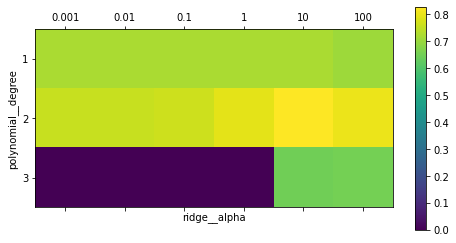

In [32]:
# 交差検証の結果をヒートマップで可視化
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1), vmin=0, cmap='viridis')
# 順番に注目!
plt.xlabel("ridge__alpha")
plt.ylabel("polynomial__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])), param_grid['polynomialfeatures__degree'])
plt.colorbar()

In [33]:
print(f"Best parameters: {grid.best_params_}")

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [34]:
print(f"Test set score: {grid.score(X_test, y_test):.2f}")

Test set score: 0.77


In [35]:
# 比較のために多項式特徴量を使わずにグリッドサーチを行う
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print(f"Score without poly features: {grid.score(X_test, y_test):.2f}")

Score without poly features: 0.63


# グリッドサーチによるモデルの選択
パイプラインで実際に行われるステップに対してもサーチすることができる。

例: StandardScalerとMinMaxScalerどちらを用いるか？

In [36]:
# ここではRandomForestClassifierとSVCを比較する。
# SVCについてはデータ変換する必要があるから、StandardScalerを使うか、何も前処理をしない蚊についても探索する必要がある
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])
# pipelineを作るときはあとでgrid_paramsで指定するため、とりあえず適当に作ってる(?)

In [39]:
# 探索する範囲をparameter_gridとして定義
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]


In [40]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print(f"Best params:\n{grid.best_params_}")
print(f"Best cross-validation score: {grid.best_score_:.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")

Best params:
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}
Best cross-validation score: 0.99
Test set score: 0.98


これでscikit-learnが提供するツールとアルゴリズムに関する説明は全て終わった。機械学習を実際の問題に適用するために必要な機構を全て知った事になる。

お疲れさま！
